# 08 Cluster Annotation
<b> Bart Theeuwes </b>

Here we determine which celltypes contribute most to each stage cluster.

In [1]:
here::i_am("01_create_arrow.R")
source(here::here("settings.R"))
source(here::here("load_archr.R"))
library(viridis)

# I/O
io$outdir =  file.path(io$output.directory,"cluster_annotation")
dir.create(io$outdir, showWarnings = FALSE)

# args
args = list()
args$matrix = 'PeakMatrix'

addArchRThreads(12)
options(repr.plot.width=15, repr.plot.height=10)


here() starts at /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/code

Setting default number of Parallel threads to 1.

Setting addArchRVerbose = FALSE

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==

In [3]:
metadata = as.data.frame(ArchRProject@cellColData)

In [4]:
colnames(metadata)

[1] "Sample"                             "TSSEnrichment"                     
 [3] "ReadsInTSS"                         "ReadsInPromoter"                   
 [5] "PromoterRatio"                      "PassQC"                            
 [7] "NucleosomeRatio"                    "nMultiFrags"                       
 [9] "nMonoFrags"                         "nFrags"                            
[11] "nDiFrags"                           "DoubletScore"                      
[13] "DoubletEnrichment"                  "sample"                            
[15] "stage"                              "Clusters_TileMatrix"               
[17] "ReadsInPeaks"                       "FRIP"                              
[19] "Clusters_PeakMatrix"                "predictedCell_Un_PeakMatrix"       
[21] "predictedGroup_celltype_PeakMatrix" "predictedScore_celltype_PeakMatrix"
[23] "stage_clusters"                     "cell"                              
[25] "celltype_v1"

In [28]:
props = as.data.table(table(metadata$Clusters_PeakMatrix, metadata$predictedGroup_celltype_PeakMatrix)) %>%
    .[,prop := round(N/sum(N) * 100, 1), by=V1] %>% .[prop>20,] %>% setorder('V1' , -'prop')
write.csv(props, sprintf("%s/cluster_celltype_prop_for_dan.csv",io$sup_figures))

In [29]:
props

V1  V2                              N    prop
1  C1  Syncytiotrophoblast progenitors  272 53.4
2  C1  Syncytiotrophoblast              237 46.6
3  C10 Dermomyotome                    1580 41.2
4  C11 Cranial neural crest             510 96.8
5  C12 Forebrain                       1496 84.0
6  C13 Hindbrain                         73 56.2
7  C14 Hindbrain                       2358 44.2
8  C14 Midbrain                        1290 24.2
9  C15 Venous endothelium               859 80.1
10 C16 Megakariocytes                   162 70.1
11 C17 Allantois                        807 42.1
12 C17 Lateral plate mesoderm           718 37.5
13 C18 Mesenchyme                       651 47.8
14 C18 Lateral plate mesoderm           596 43.8
15 C19 Cardiomyocytes FHF 2             471 93.8
16 C2  Trophoblast                      116 76.3
17 C2  Cytotrophoblast                   33 21.7
18 C20 Epiblast                        2426 83.9
19 C21 Haematoendothelial progenitors   709 35.2
20 C21 Nascent mesoderm                 593 29.5
21 C22 Epiblast                          84 28.9
22 C23 Pharyngeal endoderm              335 25.0
23 C23 NMPs                             323 24.1
24 C24 Caudal mesoderm                  414 25.8
25 C24 Presomitic mesoderm              368 23.0
26 C24 NMPs                             327 20.4
27 C25 Epiblast                        1049 72.8
28 C25 Hindbrain                        386 26.8
29 C3  Trophoblast                      498 98.2
30 C4  Cytotrophoblast                 1096 80.0
31 C5  Amnion 2                         177 79.4
32 C6  Hypoblast                         58 55.2
33 C7  Hypoblast                       2491 82.7
34 C8  Hypoblast                        699 76.2
35 C8  Visceral YS endoderm             188 20.5
36 C9  Erythroid                        728 71.7

#### Compare celltype proportions with RNA

In [4]:
# load rna metadata
rna_out = '/rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/RNA/'
# load new metadata
celltypes = fread(paste0(rna_out, 'rna_meta.tsv')) %>%
     setnames(c('V1', 'celltype'), c('cell', 'celltype')) %>%
    .[order(match(cell, colnames(counts))),]
stages = fread(paste0(rna_out, 'metadata.csv')) %>%
    setnames('index', 'cell') %>%
     .[,c('cell', 'stage')] %>%
     .[order(match(cell, colnames(counts))),] 
meta_RNA = cbind(celltypes, stages[,2])

In [5]:
# Plot proportions
pdf1 = table(meta_RNA$celltype, meta_RNA$stage)
pdf1 = as.data.frame(sweep(pdf1, 2, colSums(pdf1), "/"))
pdf1$Var3 = 'RNA'

pdf2 = table(metadata$predictedGroup_celltype_PeakMatrix, metadata$stage)
pdf2 = as.data.frame(sweep(pdf2, 2, colSums(pdf2), "/"))
pdf2$Var3 = 'ATAC'

props = rbind(pdf1, pdf2)
props = props[,c('Var1', 'Var2', 'Var3', 'Freq')]
props$Freq = as.numeric(props$Freq)

options(repr.plot.width=15, repr.plot.height=15)
p = ggplot(props, aes(Var1, Freq, fill=Var3)) + 
    geom_bar(stat='identity', position = "dodge") + 
    facet_wrap(~Var2, ncol=1) + 
    theme_bw() + 
    ylab('Proportion') + 
    theme(axis.text.x=element_text(angle=-90, vjust=0, hjust=0),
          axis.title.x=element_blank(),
         text = element_text(size=20)) 

pdf(sprintf("%s/celltype_proportions.pdf",io$outdir), width=16, height=12)
print(p)
dev.off()

png 
  2

#### Celltype annotation per cluster

In [6]:
# Plot cluster - celltype heatmap
pdf2 = table(metadata$predictedGroup_celltype_PeakMatrix, metadata$Clusters_PeakMatrix)
pdf2 = as.data.frame(sweep(pdf2, 2, colSums(pdf2), "/"))

test = dcast(pdf2, Var1 ~ Var2, value.var='Freq')
rownames(test) = test$Var1
test$Var1 = NULL
test <- scale(t(test))

ord <- hclust( dist(test, method = "euclidean"), method = "ward.D" )$order

pdf2$Var2 <- factor(pdf2$Var2, levels = rownames(test)[ord])

options(repr.plot.width=15, repr.plot.height=10)

p = ggplot(pdf2, aes(Var2, Var1, fill=Freq)) + 
    geom_tile() + 
    scale_fill_viridis() + 
    theme(text=element_text(size = 15),
         axis.title = element_blank(),
         legend.position='none') 

pdf(sprintf("%s/celltype_per_cluster.pdf",io$outdir), width=14, height=12)
print(p)
dev.off()

Warning message in dcast(pdf2, Var1 ~ Var2, value.var = "Freq"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(pdf2). In the next version, this warning will become an error.”


png 
  2

In [7]:
# Plot cluster - celltype heatmap
pdf2 = table(metadata$predictedGroup_celltype_PeakMatrix, metadata$stage_clusters)
pdf2 = as.data.frame(sweep(pdf2, 2, colSums(pdf2), "/"))

test = dcast(pdf2, Var1 ~ Var2, value.var='Freq')
rownames(test) = test$Var1
test$Var1 = NULL
test <- scale(t(test))

ord <- hclust( dist(test, method = "euclidean"), method = "ward.D" )$order

pdf2$Var2 <- factor(pdf2$Var2, levels = rownames(test)[ord])

options(repr.plot.width=15, repr.plot.height=10)

p = ggplot(pdf2, aes(Var2, Var1, fill=Freq)) + 
    geom_tile() + 
    scale_fill_viridis() + 
    theme(text=element_text(size = 15),
          axis.text.x = element_text(angle=-90, hjust=0, vjust=0),
         axis.title = element_blank(),
         legend.position='none') 

pdf(sprintf("%s/celltype_per_stagecluster.pdf",io$outdir), width=14, height=12)
print(p)
dev.off()

Warning message in dcast(pdf2, Var1 ~ Var2, value.var = "Freq"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(pdf2). In the next version, this warning will become an error.”


png 
  2

In [8]:
order = as.data.frame(metadata) %>% 
    arrange(predictedGroup_celltype_PeakMatrix, predictedScore_celltype_PeakMatrix) %>% 
    .$cell

In [9]:
p = ggplot(metadata, aes(factor(cell, levels = order), predictedGroup_celltype_PeakMatrix, fill = predictedScore_celltype_PeakMatrix)) + 
    geom_tile() + 
    scale_fill_viridis() + 
    scale_color_viridis() + 
    labs(x = 'cells', y = 'Predicted celltype', fill = 'Score') +
    theme_classic() + 
    theme(text = element_text(color='black', size = 15),
          axis.text.x = element_blank())

pdf(sprintf("%s/score_per_celltype.pdf",io$outdir), width=14, height=12)
print(p)
dev.off()

png 
  2

#### Label Clusters based on transferred label

In [353]:
cluster_anno = as.data.frame(table(metadata$stage_clusters, metadata$predictedGroup_celltype_PeakMatrix)) %>% filter(Freq>0) %>% arrange(Var1, -Freq)
write.csv(cluster_anno, sprintf('%s/cluster_annotation.csv', io$outdir))

In [21]:
annos = as.data.table(metadata) %>% 
    .[,.(mean(predictedScore_celltype_PeakMatrix), .N), by=.(stage_clusters, predictedGroup_celltype_PeakMatrix)] %>%
    .[,prop:=N/sum(N), by=stage_clusters] %>%
    .[order(-prop)] %>%
    setnames('V1', 'mean_score')

In [58]:
# Get celltype of most abundant celltypes per cluster
# if 2 celltypes have > 40% contribution, label as both
# if none have >40% contribution, name as highest contribution with '_?' 
anno_celltypes = rbindlist(lapply(unique(annos$stage_clusters), function(x){
    tmp = annos[stage_clusters==x]
    celltypes = paste(tmp[prop > 0.4]$predictedGroup_celltype_PeakMatrix, collapse='_')
    if(max(tmp$prop) <=0.4){
        celltypes = paste0(tmp[prop==max(prop)]$predictedGroup_celltype_PeakMatrix, '_?')
    }
    celltypes = data.frame(stage_clusters = x, celltype_v1 = celltypes)
    return(celltypes)
}))

In [63]:
# make apendable to metadata
anno_celltypes = anno_celltypes %>% .[match(ArchRProject@cellColData$stage_clusters, stage_clusters)]
summary(anno_celltypes$stage_clusters == ArchRProject@cellColData$stage_clusters)

   Mode    TRUE 
logical   34082 

In [64]:
ArchRProject@cellColData$celltype_v1 = anno_celltypes$celltype_v1

Length of unique values greater than palette, interpolating..

Length of unique values greater than palette, interpolating..



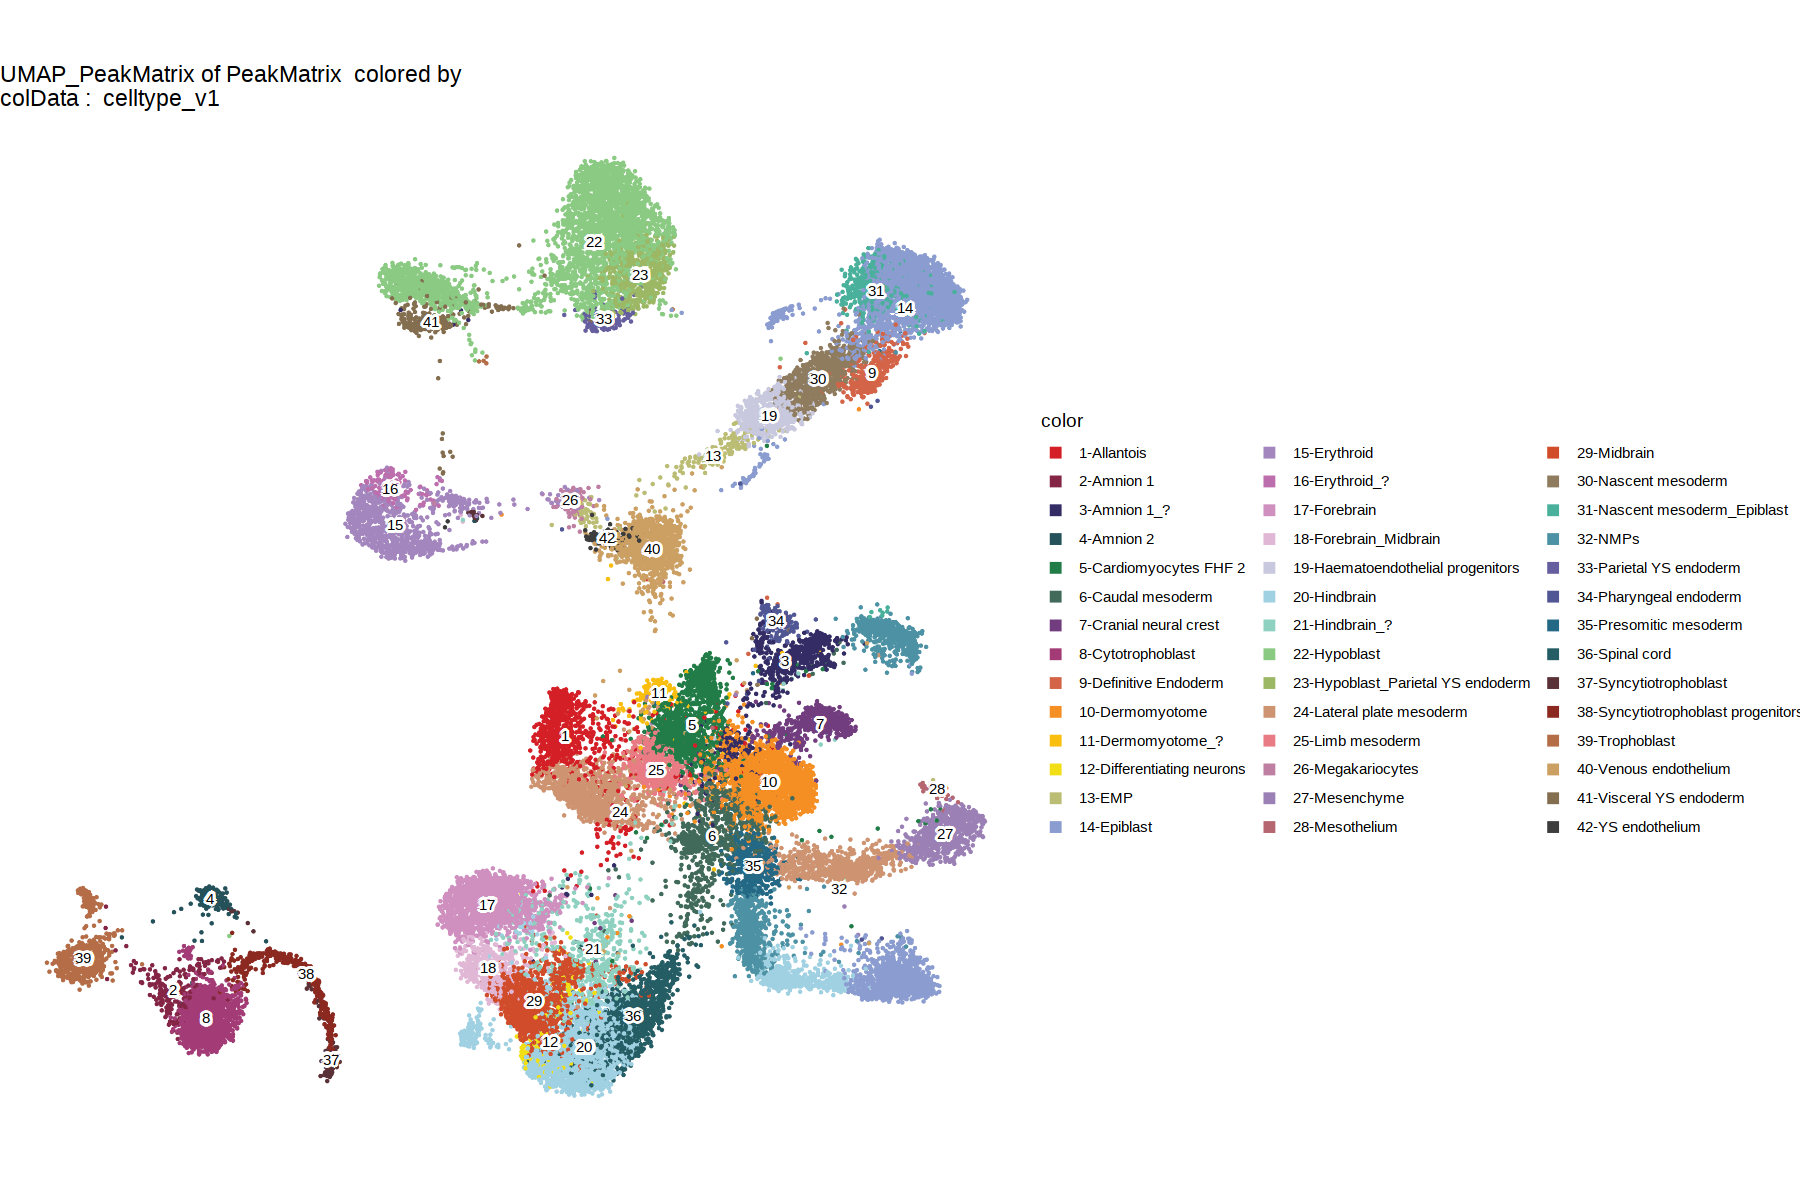

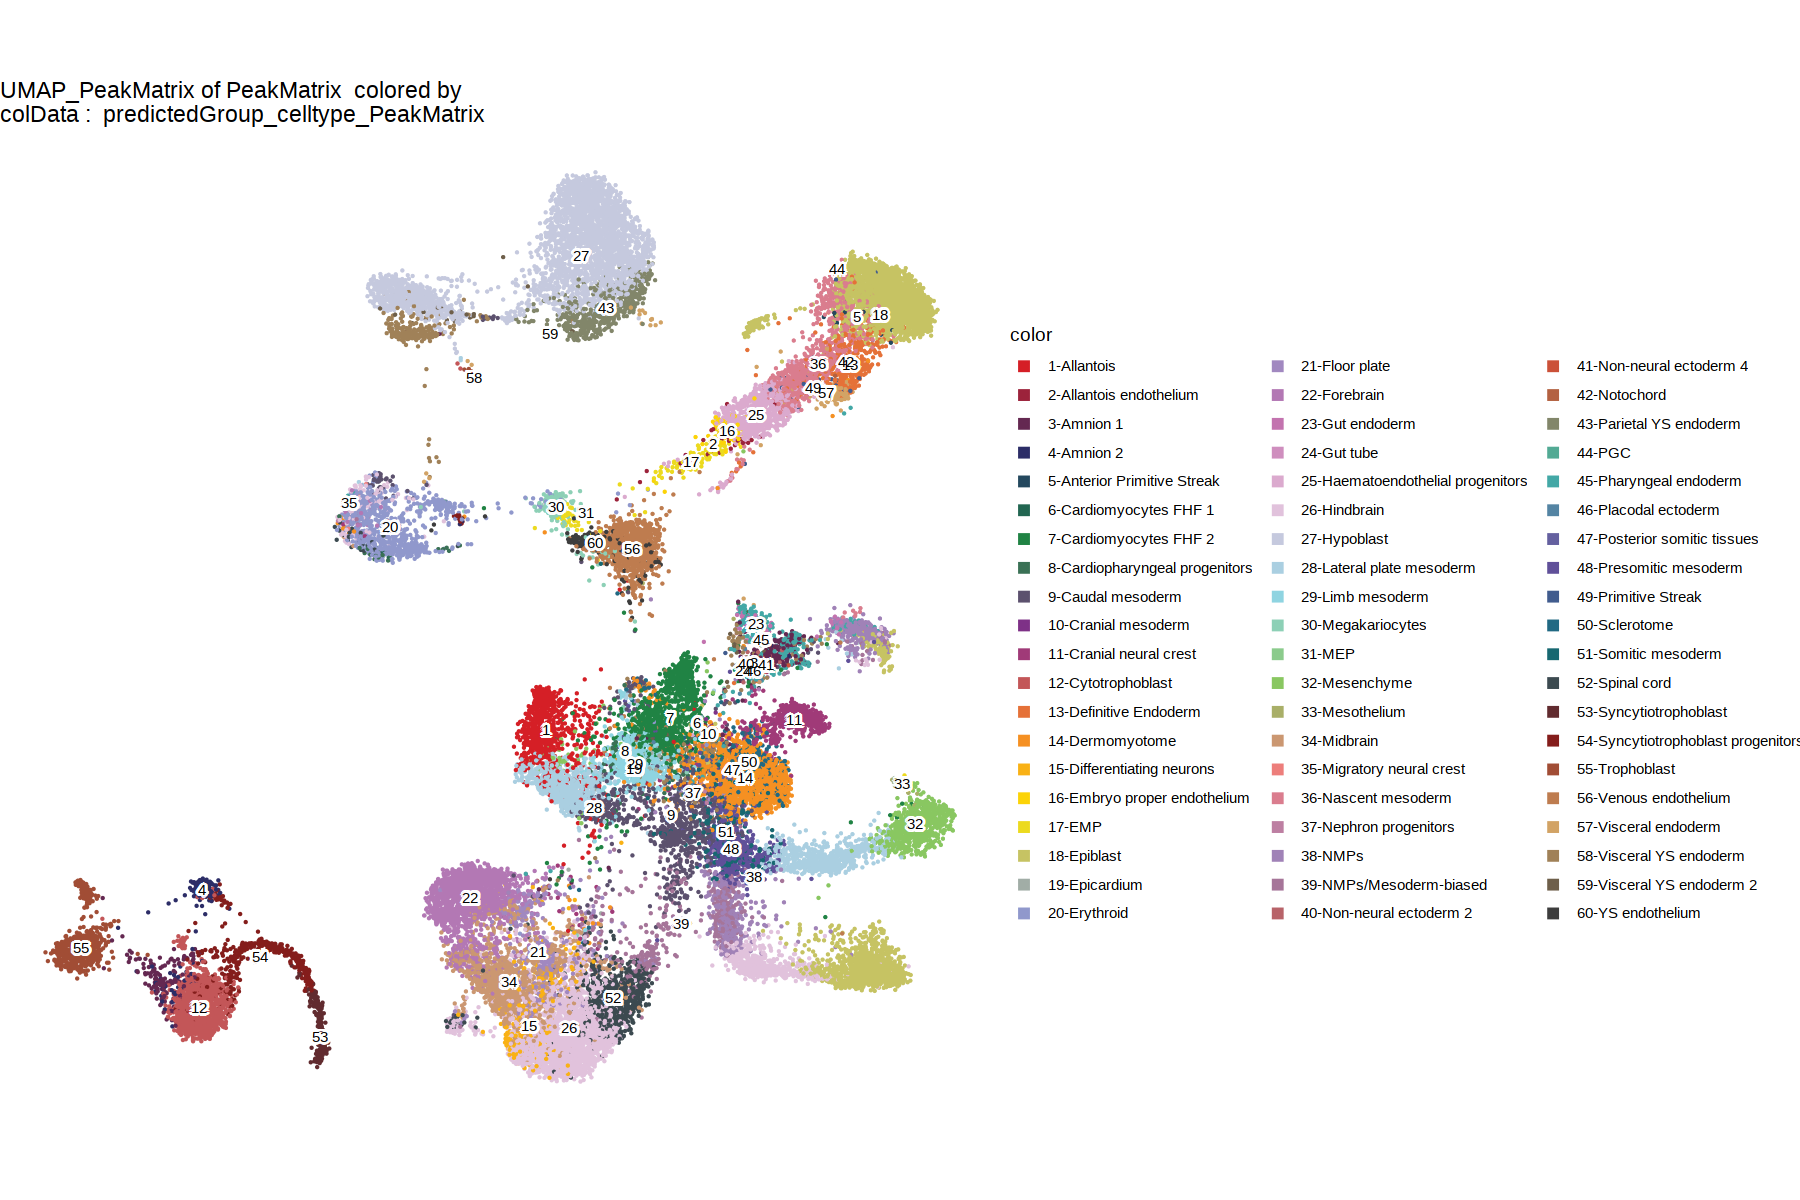

In [65]:
plotEmbedding(
  ArchRProj = ArchRProject,
  embedding = "UMAP_PeakMatrix",
  colorBy = "cellColData",
  name = "celltype_v1") + theme_void()

plotEmbedding(
  ArchRProj = ArchRProject,
  embedding = "UMAP_PeakMatrix",
  colorBy = "cellColData",
  name = "predictedGroup_celltype_PeakMatrix") + theme_void()

In [66]:
archr_meta = as.data.frame(getCellColData(ArchRProject))

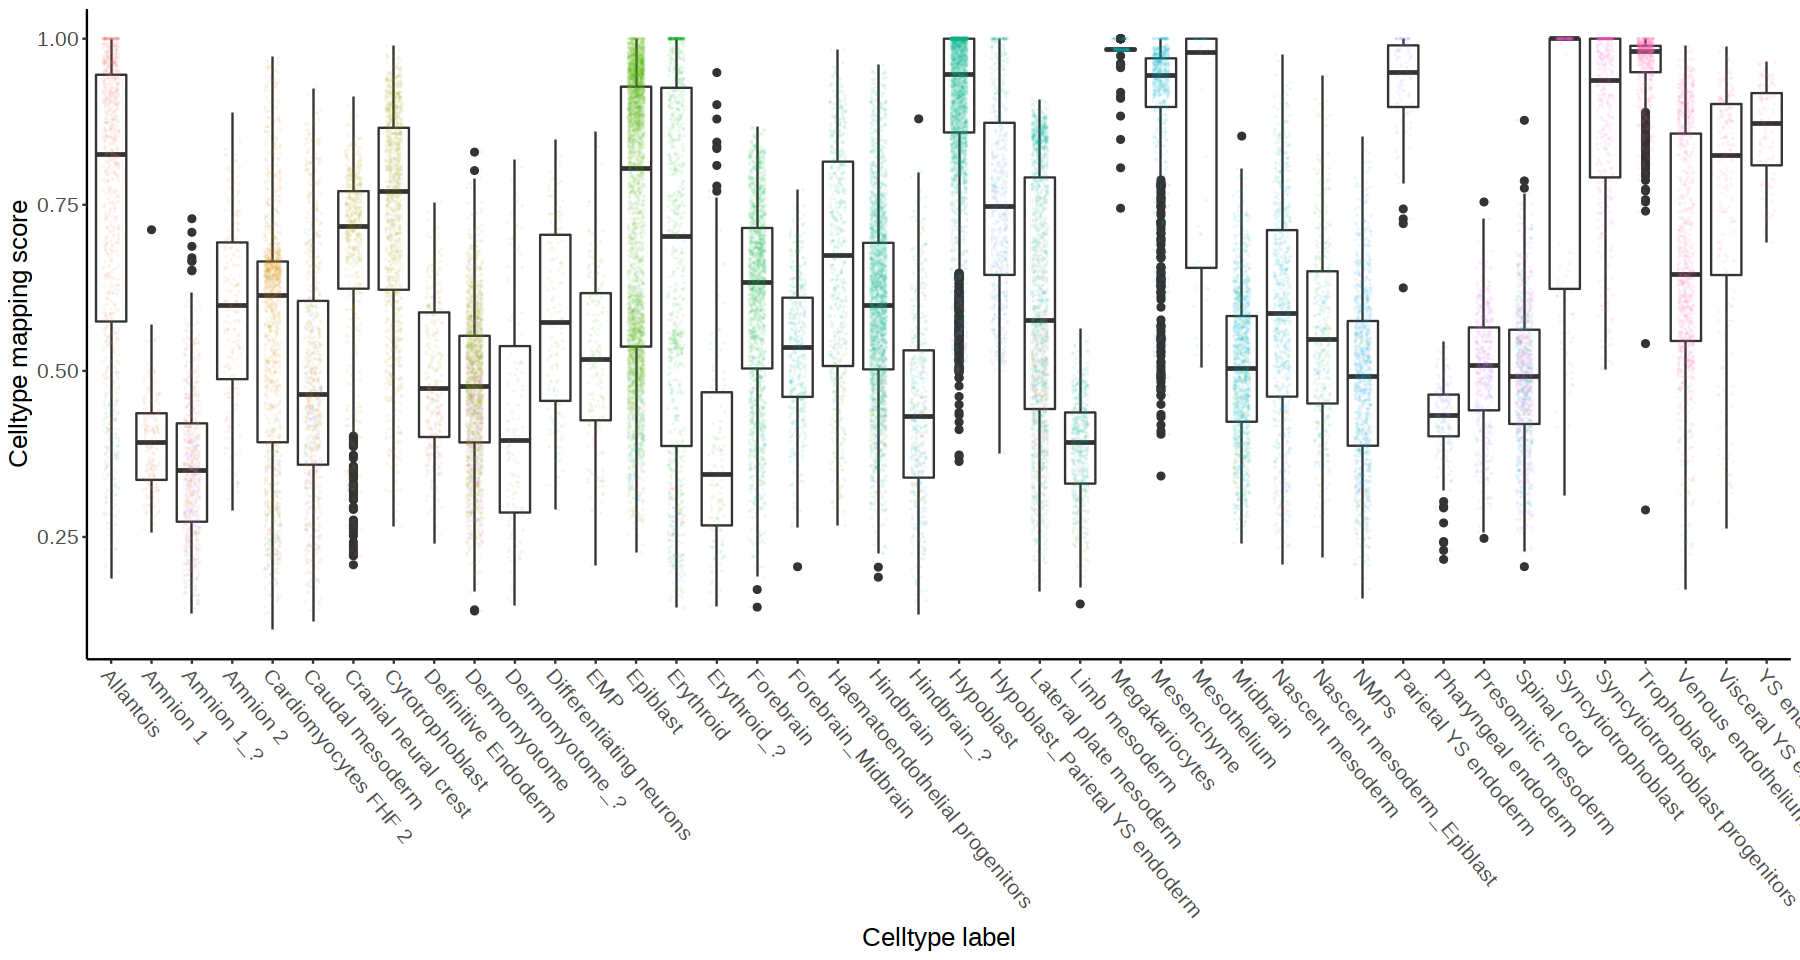

In [68]:
options(repr.plot.width=15, repr.plot.height=8)

ggplot(archr_meta, aes(celltype_v1, predictedScore_celltype_PeakMatrix)) + 
        geom_boxplot() + 
        geom_jitter(position=position_jitter(0.2), size = 0.001, alpha = 0.05, aes(col=predictedGroup_celltype_PeakMatrix)) + 
        xlab('Celltype label') + ylab('Celltype mapping score') + 
        theme_classic() + theme(text = element_text(size=15, color='black'),
                                axis.text.x=element_text(angle=-50, hjust=0),
                               legend.position='none')

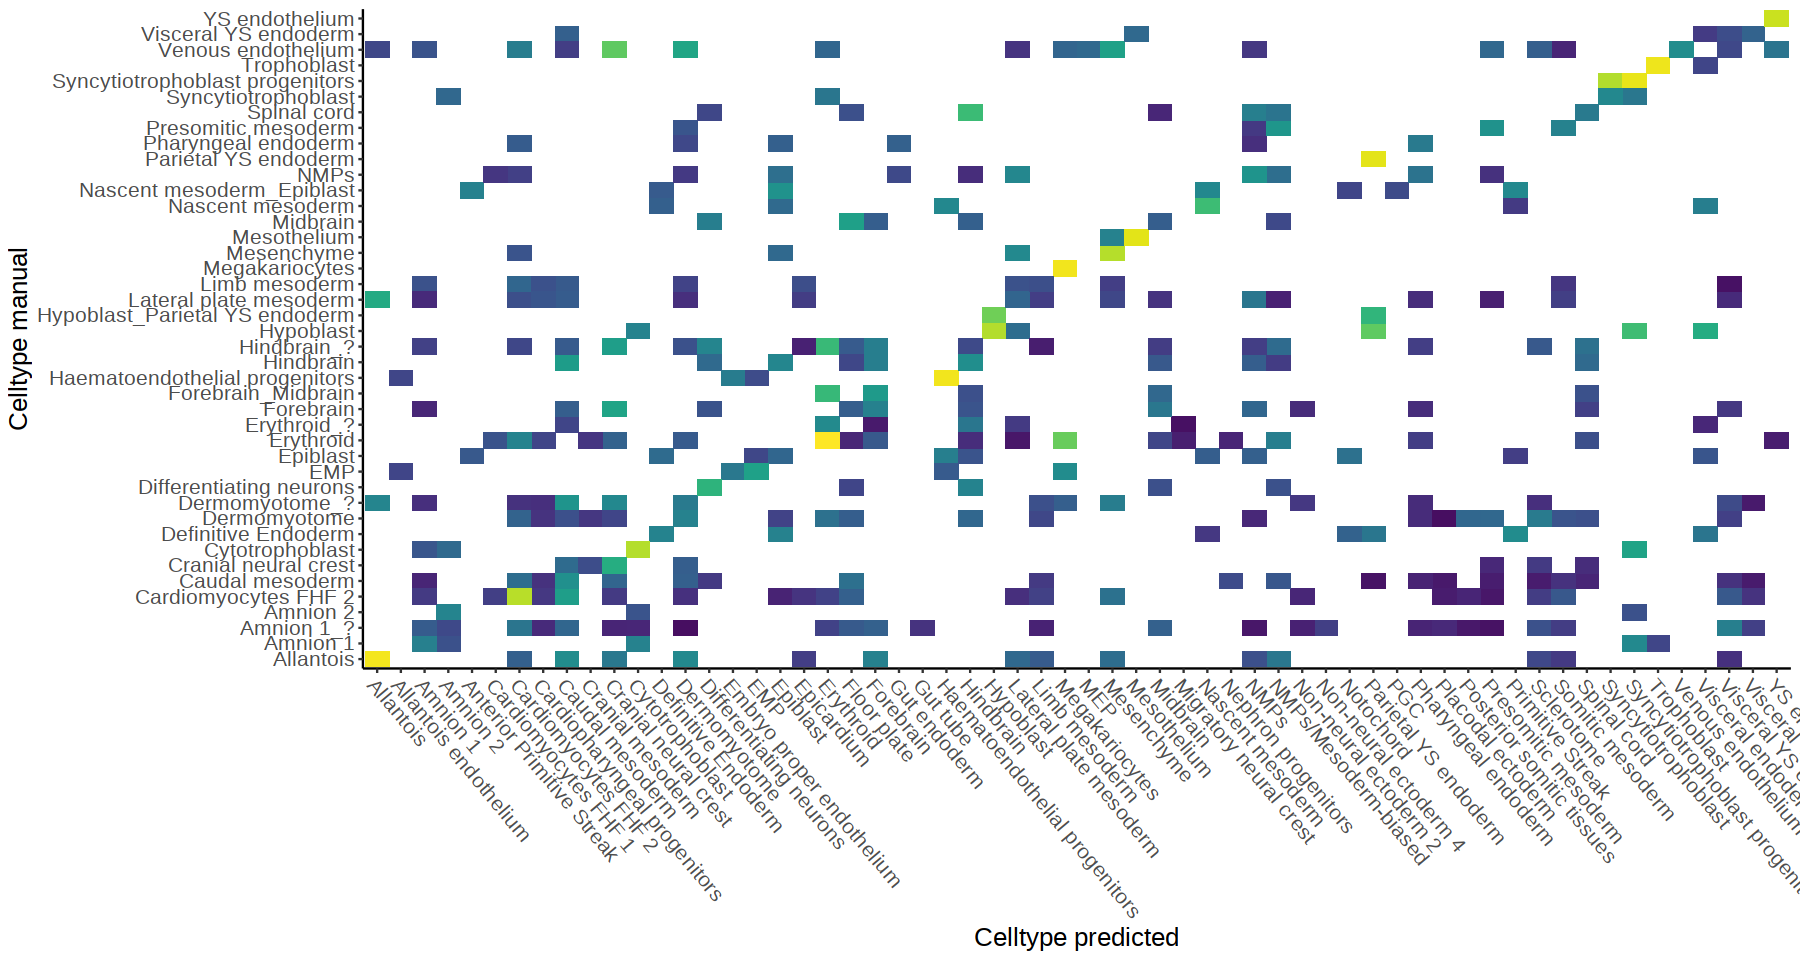

In [69]:
options(repr.plot.width=15, repr.plot.height=8)

ggplot(archr_meta, aes(predictedGroup_celltype_PeakMatrix, celltype_v1,  fill=predictedScore_celltype_PeakMatrix)) + 
        geom_tile() +
        scale_fill_viridis() +
        xlab('Celltype predicted') + ylab('Celltype manual') + 
        theme_classic() + theme(text = element_text(size=15, color='black'),
                                axis.text.x=element_text(angle=-50, hjust=0),
                               legend.position='none')

In [70]:
pdf1 = table(archr_meta$predictedGroup_celltype_PeakMatrix, archr_meta$celltype_v1)
pdf1 = as.data.frame(sweep(pdf1, 2, colSums(pdf1), "/"))

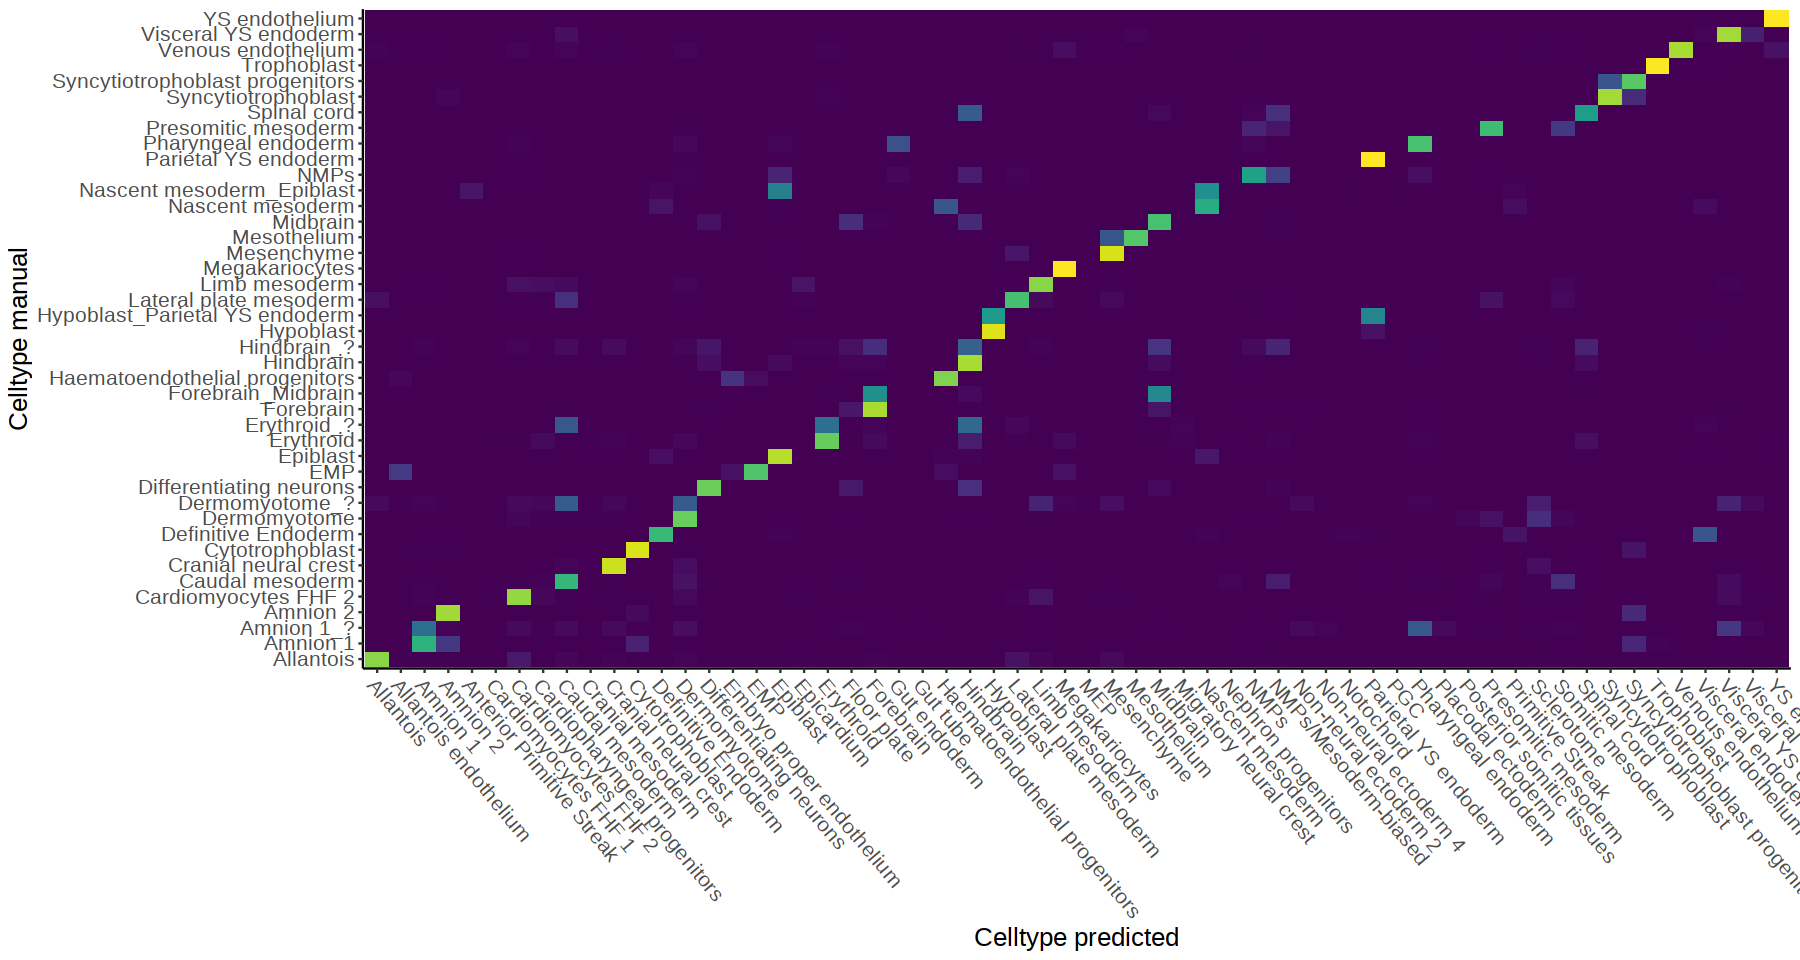

In [71]:
ggplot(pdf1, aes(Var1, Var2,  fill=Freq)) + 
        geom_tile() +
        scale_fill_viridis() +
        xlab('Celltype predicted') + ylab('Celltype manual') + 
        theme_classic() + theme(text = element_text(size=15, color='black'),
                                axis.text.x=element_text(angle=-50, hjust=0),
                               legend.position='none')

In [72]:
saveArchRProject(ArchRProj = ArchRProject)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

class: ArchRProject 
outputDirectory: /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project 
samples(8): rabbit_BGRGP1 rabbit_BGRGP2 ... rabbit_BGRGP7 rabbit_BGRGP8
sampleColData names(1): ArrowFiles
cellColData names(25): Sample TSSEnrichment ... cell celltype_v1
numberOfCells(1): 34082
medianTSS(1): 3.615
medianFrags(1): 33602

#### Find markers per celltype cluster

In [75]:
getAvailableMatrices(ArchRProject)

[1] "GeneIntegrationMatrix_PeakMatrix" "GeneScoreMatrix"                 
[3] "MotifMatrix"                      "PeakMatrix"                      
[5] "TileMatrix"

In [76]:
find_markers = function(matrix, FDR=0.05, log2FC=1.25, ntop=4){
    markers <- getMarkerFeatures(
        ArchRProj = ArchRProject, 
        useMatrix = matrix, 
        groupBy = "celltype_v1",
        bias = c("TSSEnrichment", "log10(nFrags)"),
        testMethod = "wilcoxon"
    )
    saveRDS(markers, file.path(io$outdir, sprintf('markers_%s.rds', matrix)))

    heatmapGS <- plotMarkerHeatmap(
        seMarker = markers, 
        cutOff = sprintf("FDR <= %s & Log2FC >= %s", FDR, log2FC),
      nLabel = ntop,
      nPrint = ntop
    )

    options(repr.plot.width=15, repr.plot.height=8)
    ComplexHeatmap::draw(heatmapGS, heatmap_legend_side = "bot", annotation_legend_side = "bot")
    plotPDF(heatmapGS, name = paste0('heatmap_', matrix), width = 9, height = 40, ArchRProj = ArchRProject, addDOC = FALSE)   
}

In [77]:
# Markers PeakMatrix
#suppressMessages(find_markers('PeakMatrix', ntop=2))

  [1] "chr12:ENSOCUG00000006836" "chr19:TBX4"              
  [3] "chr2:ENSOCUG00000033766"  "chr7:COL3A1"             
  [5] "chr1:ENSOCUG00000036366"  "chr1:KCNV2"              
  [7] "chr1:ENSOCUG00000022148"  "chr10:CCDC126"           
  [9] "chr1:ENSOCUG00000033635"  "chr1:ENSOCUG00000030169" 
 [11] "chr1:ENSOCUG00000027323"  "chr1:ENSOCUG00000026948" 
 [13] "chr1:ENSOCUG00000037152"  "chr1:ENSOCUG00000026996" 
 [15] "chr1:OMD"                 "chr1:ENSOCUG00000027736" 
 [17] "chr1:ENSOCUG00000039557"  "chr14:POPDC2"            
 [19] "chr17:SNORD115"           "chr1:ENSOCUG00000039354" 
 [21] "chr19:HOXB9"              "chr19:HOXB8"             
 [23] "chr4:ENSOCUG00000001160"  "chr1:ENSOCUG00000034045" 
 [25] "chr10:ENSOCUG00000001018" "chr12:SLC2A12"           
 [27] "chr13:ASIC3"              "chr1:CER1"               
 [29] "chr14:ENSOCUG00000030439" "chr15:Metazoa_SRP"       
 [31] "chr9:ENSOCUG00000004992"  "chr14:ENSOCUG00000026179"
 [33] "chr16:ENSOCUG00000039059" "chr3:E

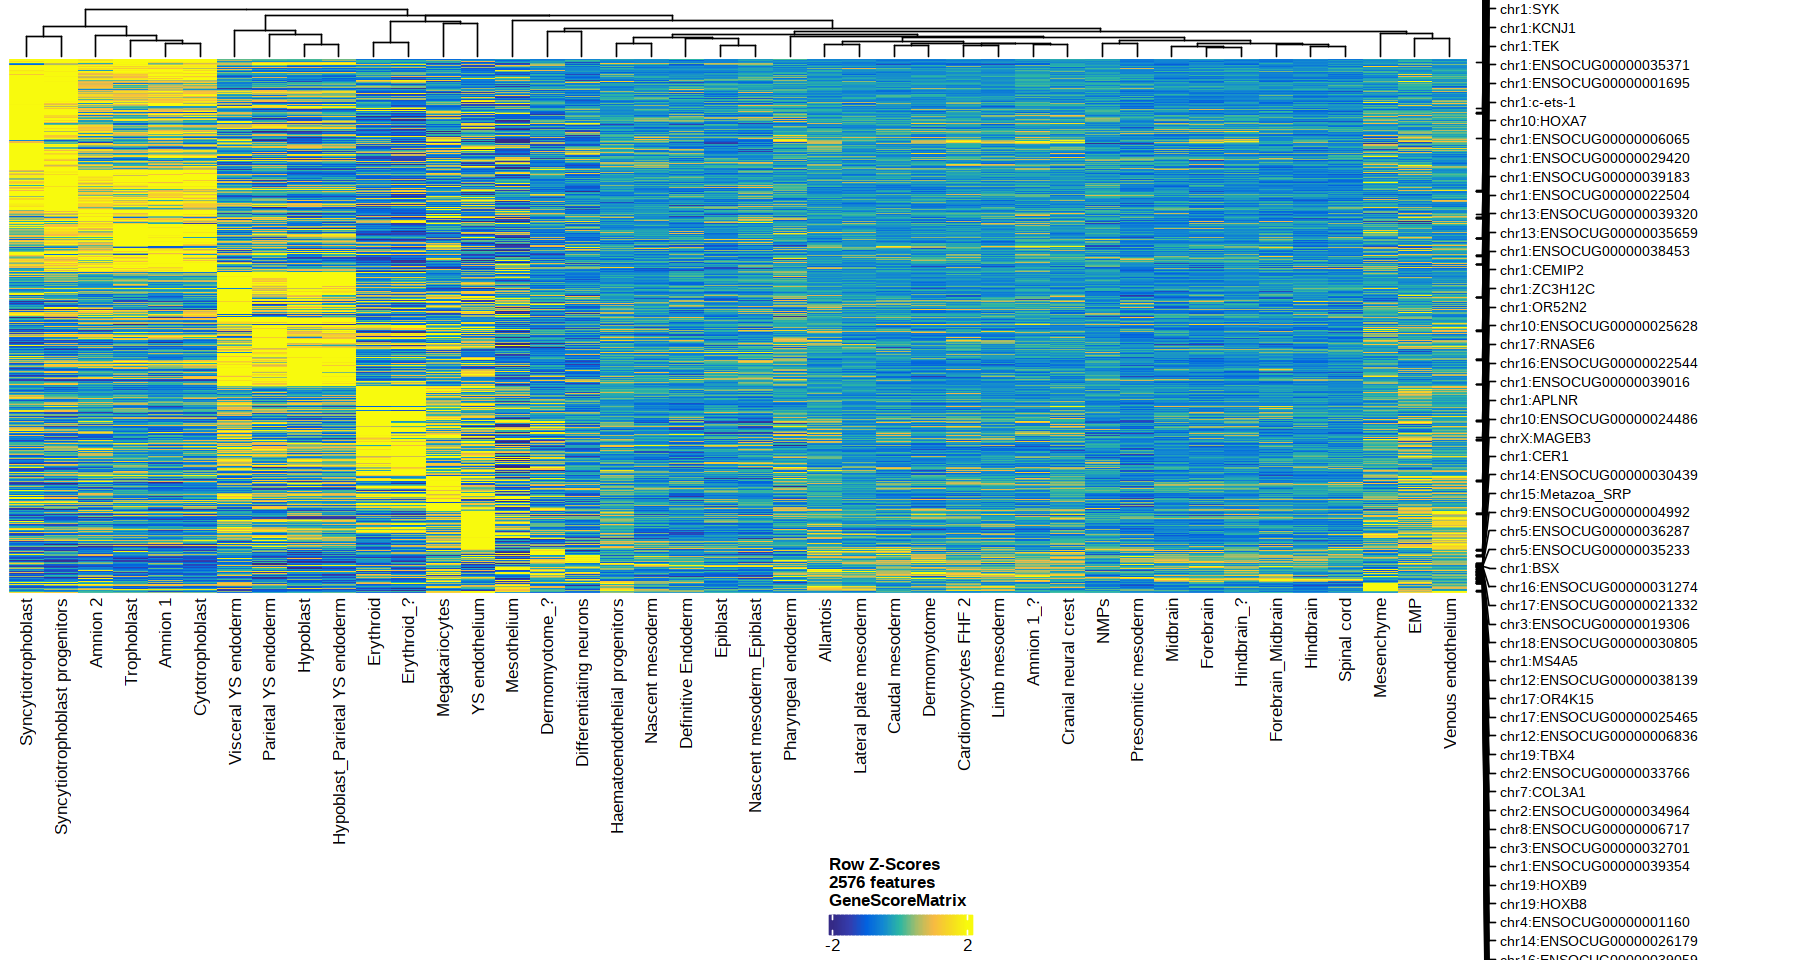

In [78]:
# Markers GeneScoreMatrix
suppressMessages(find_markers('GeneScoreMatrix', ntop=4))

Most markers are for trophoblast or hypoblast celltypes. For the analysis of the embryo proper this will have to be rerun on a subsetted dataset with only embryo proper cells

  [1] "chr1:NANS"                "chr1:ENSOCUG00000038592" 
  [3] "chr1:ENSOCUG00000026843"  "chr1:ENSOCUG00000031288" 
  [5] "chr1:KIAA2026"            "chr1:RHOG"               
  [7] "chr12:ENSOCUG00000024862" "chr12:ENSOCUG00000019045"
  [9] "chr1:ENSOCUG00000019225"  "chr1:ENSOCUG00000037326" 
 [11] "chr1:ADAMTS15"            "chr1:ENSOCUG00000034158" 
 [13] "chr1:ENSOCUG00000030804"  "chr1:ENSOCUG00000036924" 
 [15] "chr1:USP47"               "chr1:TEAD1"              
 [17] "chr1:TMOD1"               "chr1:C9orf72"            
 [19] "chr1:PTS"                 "chr1:CRYAB"              
 [21] "chr1:ACTL7A"              "chr1:OR52W1"             
 [23] "chr1:NAV2"                "chr1:LRRC55"             
 [25] "chr1:ENSOCUG00000019014"  "chr1:RPUSD4"             
 [27] "chr1:CRTAM"               "chr1:ENSOCUG00000035434" 
 [29] "chr1:ENSOCUG00000038133"  "chr1:XRRA1"              
 [31] "chr1:RELT"                "chr1:OR9Q2"              
 [33] "chr1:ENSOCUG00000029006"  "chr1:I

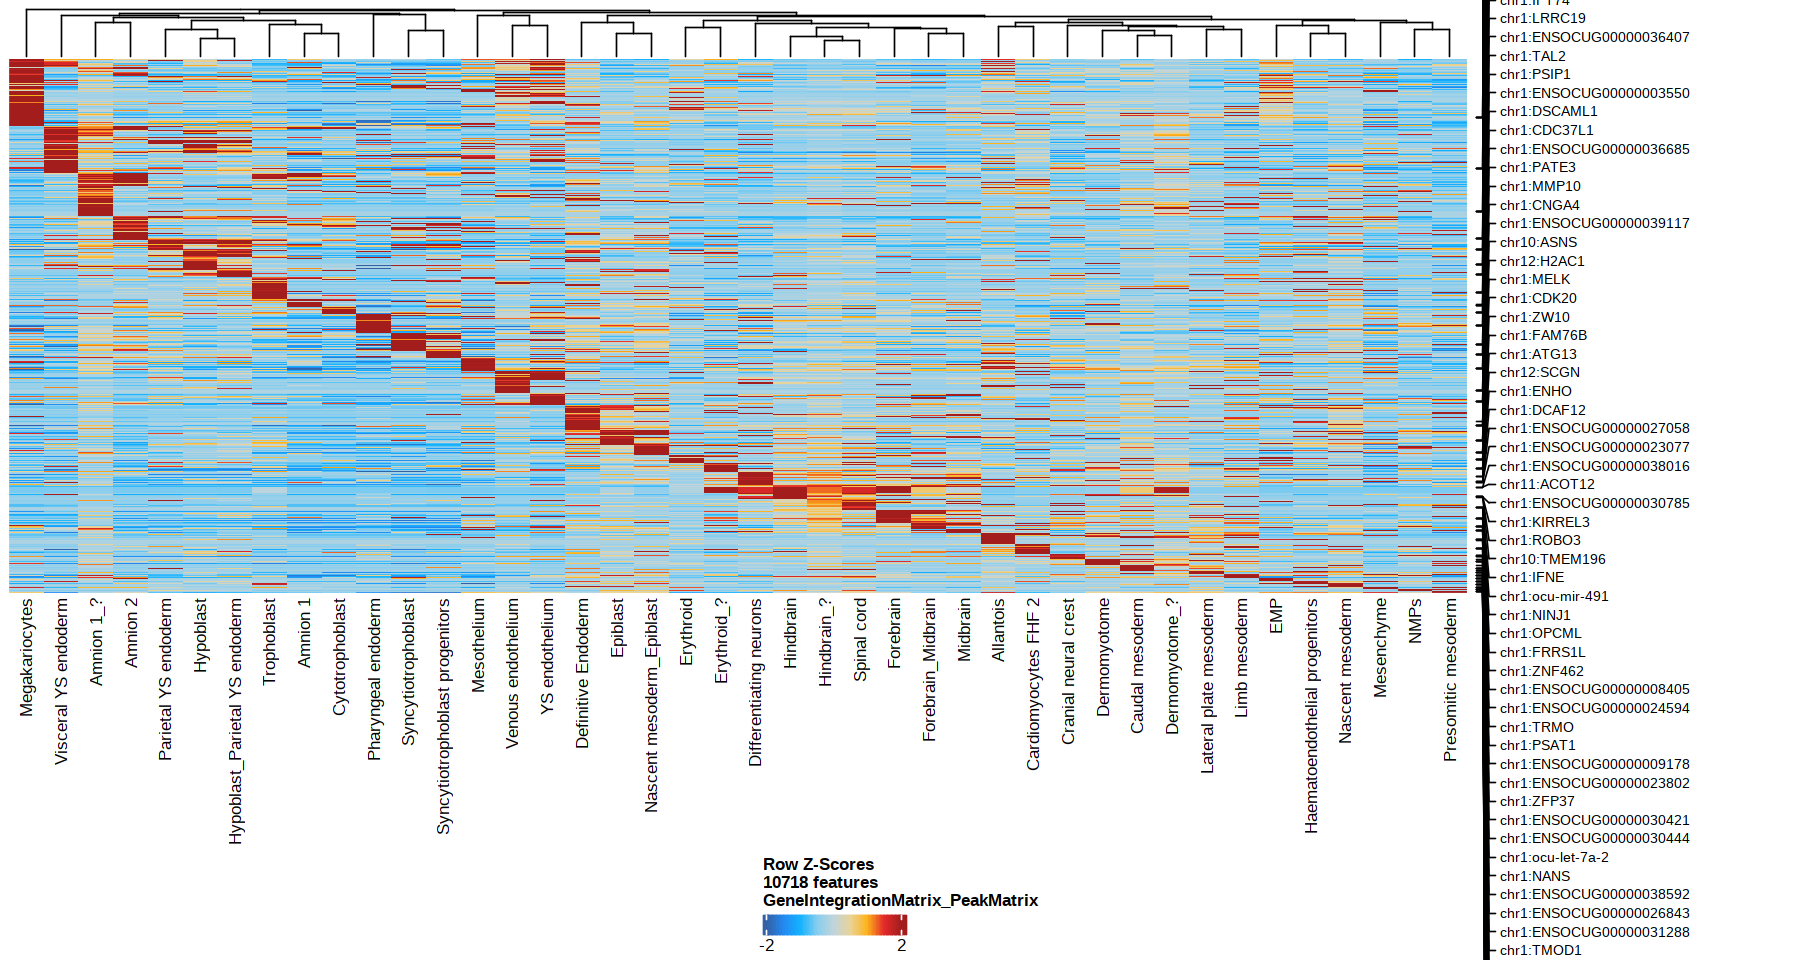

In [79]:
# Markers GeneScoreMatrix
suppressMessages(find_markers('GeneIntegrationMatrix_PeakMatrix', ntop=4))

#### Plot valcano plot per celltype cluster (geneIntegration)

In [80]:
# Plot markers of geneIntegration Matrix
markers = readRDS( file.path(io$outdir, sprintf('markers_%s.rds', 'GeneIntegrationMatrix_PeakMatrix')))

plot_volcano = function(celltype, n=25, FDR_thr=0.01, LogFC_thr = 1.25){
    
    ct_markers = markers[,colnames(markers)== celltype]
    ct_markers = ct_markers[order(-abs(ct_markers@assays@data$Log2FC))]

    to.plot = data.table(x = ct_markers@assays@data$Log2FC, y = ct_markers@assays@data$FDR, name=rowData(ct_markers)$name) %>%
        setnames(c('x.x', 'y.x'), c('LogFC', 'FDR')) %>% 
        .[,name:= gsub('ENSOCUG000000', 'ID_', name)] %>%
        .[,Diff:=ifelse(LogFC>LogFC_thr & FDR<FDR_thr, 'Up', ifelse(LogFC<=-LogFC_thr & FDR<FDR_thr, 'Down', 'non'))]

    ggplot(to.plot[abs(LogFC)>0,], aes(LogFC, -log10(FDR), col=Diff)) + 
        geom_point() + 
        scale_color_manual(values=c('blue', 'gray70', 'red'), name='Significant') + 
        geom_hline(yintercept = -log10(FDR_thr), linetype = 'dashed', color = 'gray30') +
        geom_vline(xintercept = c(-LogFC_thr, LogFC_thr), linetype = 'dashed', color = 'gray30') +
        geom_vline(xintercept = 0, linetype = 'dashed', color = 'black') +
        ggtitle(celltype,
               sprintf('Down: %d, Up: %d', nrow(to.plot[Diff=='Down', ]), nrow(to.plot[Diff=='Up', ]))) + 
        ggrepel::geom_label_repel(data=to.plot[LogFC<LogFC_thr & FDR<=FDR_thr,][!grep('ID_', name),] %>% top_n(n, -LogFC), 
                                    aes(LogFC, -log10(FDR), label=name),
                                    max.overlaps=Inf,
                                    box.padding = 0.3) + 
        ggrepel::geom_label_repel(data=to.plot[LogFC>LogFC_thr & FDR<=FDR_thr ,][!grep('ID_', name),] %>% top_n(n, LogFC), 
                                    aes(LogFC, -log10(FDR), label=name),
                                    max.overlaps=Inf,
                                    box.padding = 0.3) +
        theme_bw() + 
        theme(text=element_text(size=15, color='black'), 
              legend.position='none')
}

In [81]:
celltypes = unique(ArchRProject@cellColData$celltype_v1)

pdf(file.path(io$outdir, 'volcano_plots_celltype_v1.pdf'), width=10, height=9)
lapply(celltypes, plot_volcano)
dev.off()

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data fra

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]

[[19]]

[[20]]

[[21]]

[[22]]

[[23]]

[[24]]

[[25]]

[[26]]

[[27]]

[[28]]

[[29]]

[[30]]

[[31]]

[[32]]

[[33]]

[[34]]

[[35]]

[[36]]

[[37]]

[[38]]

[[39]]

[[40]]

[[41]]

[[42]]


png 
  2

#### UMAP with labels on top

In [73]:
colors = 'celltype_v1'

    # Fetch UMAP coordinates
    umap.dt <- getEmbedding(ArchRProject,paste0("UMAP_PeakMatrix")) %>%
      round(2) %>%
      as.data.table(keep.rownames = T) %>%
      setnames(c("cell","umap1","umap2"))

        # Plot
    sample_metadata = as.data.frame(getCellColData(ArchRProject))
    to.plot <- umap.dt %>%
      merge(sample_metadata,by="cell")
    to.plot <- umap.dt %>%
      merge(sample_metadata,by="cell")

labels = to.plot[,list(median(umap1), median(umap2)), 
                                  by= colors] %>%
        setnames(c('V1', 'V2'), c('umap1', 'umap2'))

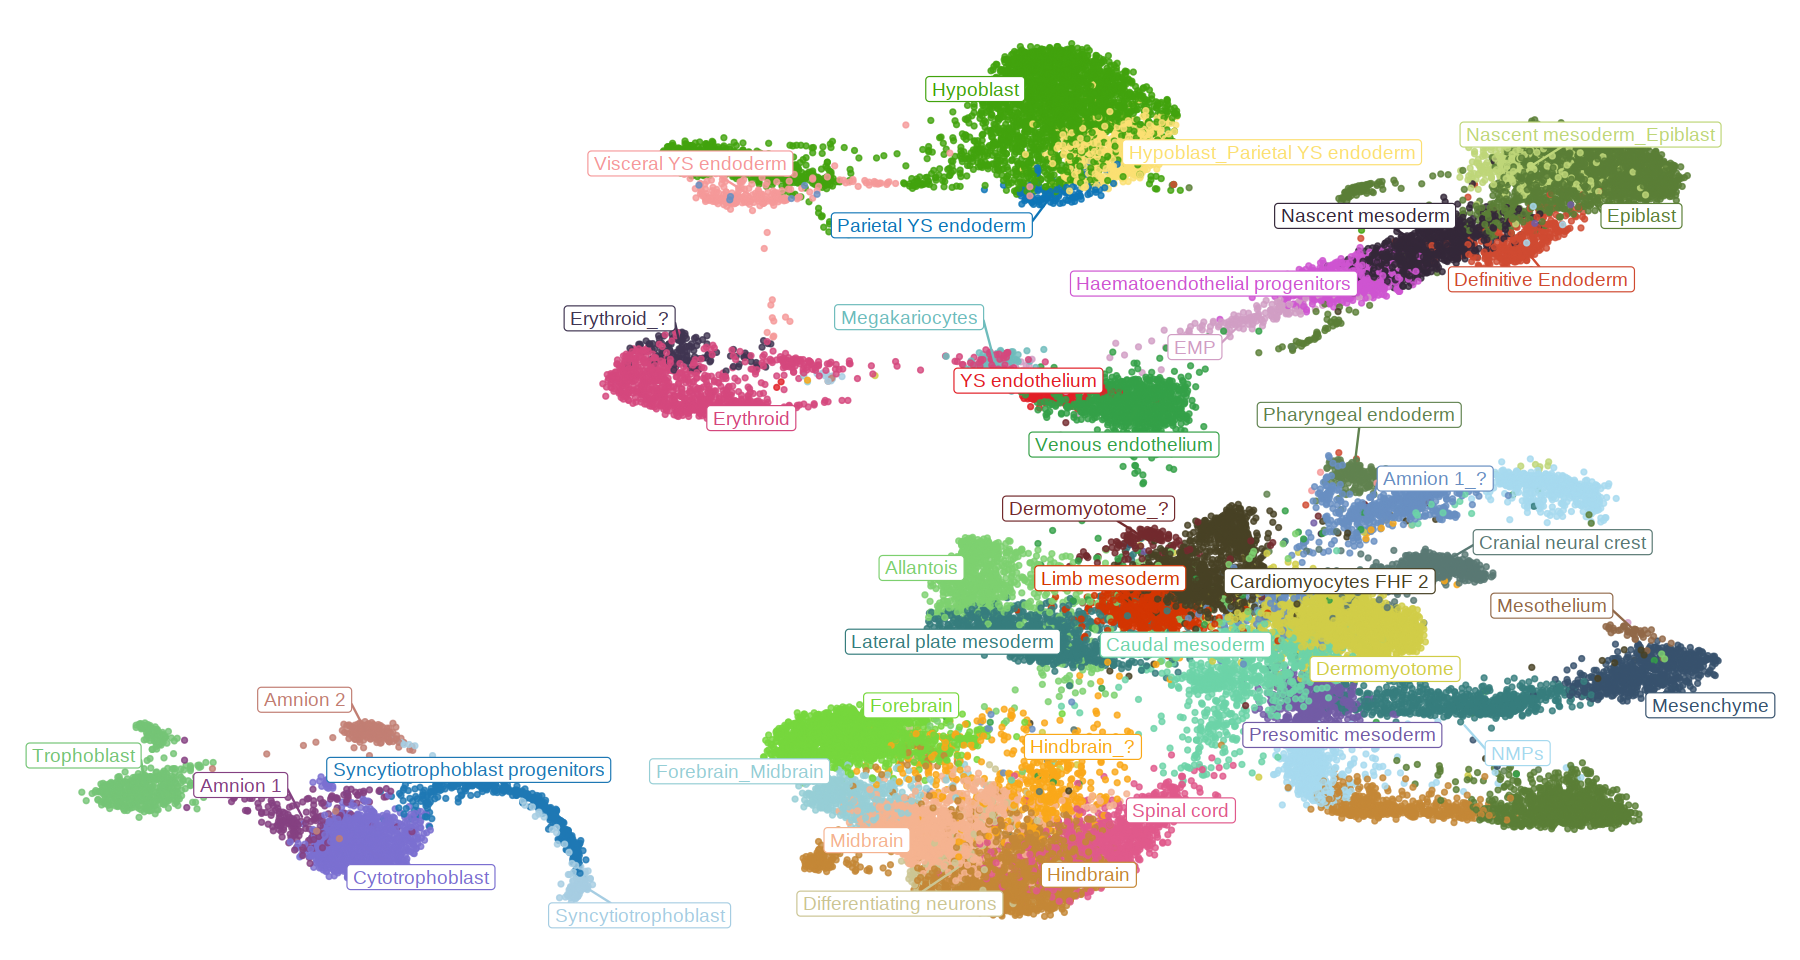

In [74]:
ggplot(to.plot, aes_string(x="umap1", y="umap2", color=colors)) +
    geom_point(size=1, alpha=0.8) + 
    scale_color_manual(values = as.vector(c(ArchRPalettes[[3]],ArchRPalettes[[5]], ArchRPalettes[[8]],ArchRPalettes[[9]]))[1:length(unique(to.plot[[colors]]))]) + 
    ggrepel::geom_label_repel(data=labels, 
                                aes_string('umap1', 'umap2', label=colors, color=colors), 
                                max.overlaps=Inf,
                                box.padding = 0.8) + 
    theme_void() + 
    theme(legend.position='none')